In [1]:
import os
import numpy as np
from scipy.integrate import cumtrapz
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.linewidth'] = 1.75 #set the value globally
mpl.rcParams.update(mpl.rcParamsDefault)
%config InlineBackend.figure_format = 'retina'

In [2]:
def solve_DBL(bandgap, plot=False):
    
    '''
    This function calculates the detailed balance limit for a given bandgap.
    '''
    
    # Constants
    k = 1.38064852e-23  # J/K 			  , boltzman constant
    k_eV = 8.617333262145e-5 # eV/k 	  , Boltzman constant
    h = 6.62607004e-34   # m^2 kg s^-1    , planck constant
    c = 2.99792458e8     # m s^-1         , speed of light
    eV = 1.6021766208e-19  # joule        , eV to joule
    q = 1.6021766208e-19  # C             , elemental charge
    T = 300 # K 						  , temperature    
    
    fn_1 = os.path.join('Spectrum_Import','AM15.csv')

    S = pd.read_csv(fn_1, delimiter=',', header=0)
    WL_1, solar_per_nm_1 = S.iloc[:,0], S.iloc[:,1]

    # Conversion from wavelength to energy
    E_1 = 1239.8 / WL_1  # eV

    # Calculate integrated power of the irradiance
    total_power_1=np.trapz(solar_per_nm_1, x=WL_1)

    # Convert to W m^-2 eV^-1
    solar_per_E_1 = solar_per_nm_1 * (eV/1e-9) * h * c / (eV*E_1)**2 

    Bandgap = np.arange(0.1, 4, 0.01)
    
    # Interpolate to make the spacing equal and avoid bias in the integration
    AM15 = np.interp(Bandgap, E_1[::-1], solar_per_E_1[::-1])  # W m^-2 eV^-1

    # Convert irradiance into photon flux 
    AM15flux = AM15 / (Bandgap*eV)  # number of photon m^-2 eV^-1 s^-1

    # Calculate cumulative integral
    fluxcumm_1 = cumtrapz(AM15flux[::-1], Bandgap[::-1], initial=0) #[::-1] enables reverse order vector

    # Reverse the order of the photon flux
    fluxaboveE_1 = fluxcumm_1[::-1] * -1 
    
    # Convert the photon flux to a Jsc in mA
    Jsc_1 = fluxaboveE_1 * q / 10  # mA/cm^2  (/10: from A/m2 to mA/cm2)
    
    # Convert planck's black body radiation law eqn 10.18 (Jager) to efficient photon flux following eqn. 8a-8d (DOI:https://doi.org/10.1016/0927-0248(95)80004-2)
    J0_prime =  (2 * q * np.pi * (Bandgap*eV)**2)  / ((c**2) * (h**3) * ((np.exp(Bandgap*eV / (k*T)) - 1)))

    # Integrate over interested bandgaps in reverse
    fluxcumm = cumtrapz(J0_prime[::-1], Bandgap[::-1], initial=0)
    fluxaboveE = fluxcumm[::-1] * -1	

    # Convert flux to current density
    J0 = fluxaboveE * q / 10  # ( from A/m2 to mA/cm2)
    J0[-1] = np.nan  # div by 0 error otherwise for Voc calc

    # Calculate Voc using diode equation
    Voc = (k_eV*T) * np.log((Jsc_1/J0) + 1)

    # Calculate FF using accurate approximation
    FF = ((q*Voc)/(k*T) - (np.log((q*Voc)/(k*T)+.72)))/(((q*Voc)/(k*T))+1)

    # Calculate PCE using SQ assumptions
    PCE = 100*((Jsc_1*10 * Voc * FF) / total_power_1) # PCE in percent, Jsc was in mA so x10
    
    # Interpolate values for given bandgap
    PCE_answer = np.round(np.interp(bandgap, Bandgap, PCE), 4) # %
    FF_answer = np.round(np.interp(bandgap, Bandgap, FF)*100, 4) # %
    Voc_answer = np.round(np.interp(bandgap, Bandgap, Voc), 4) # eV
    Jsc_answer = np.round(np.interp(bandgap, Bandgap, Jsc_1), 4)  # mA/cm^2
    J0_answer = np.interp(bandgap, Bandgap, J0)  # mA/cm^2

    # Collect all results into a dictionary
    DBL = {'PCE': PCE_answer, 'FF': FF_answer, 'Jsc': Jsc_answer, 'Voc': Voc_answer, 'J0': J0_answer}
    
    # Add plotting functionality if 'plot' argument is true
    if plot:
        fig, axs = plt.subplots(2, 2, figsize=(7,5))

        # PCE plot
        axs[0, 0].plot(Bandgap, PCE, label='PCE')
        axs[0, 0].plot(bandgap, PCE_answer, 'rx')
        axs[0, 0].annotate(f"{PCE_answer}%", (bandgap, PCE_answer), textcoords="offset points", xytext=(-20,-20), ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))
        axs[0, 0].set_title('PCE vs Bandgap')
        axs[0, 0].set_xlabel('Bandgap (eV)')
        axs[0, 0].set_ylabel('PCE (%)')
        axs[0, 0].minorticks_on()
        axs[0, 0].legend()

        # FF plot
        axs[0, 1].plot(Bandgap, FF*100, label='FF')
        axs[0, 1].plot(bandgap, FF_answer, 'rx')
        axs[0, 1].annotate(f"{FF_answer}%", (bandgap, FF_answer), textcoords="offset points", xytext=(-20,-20), ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))
        axs[0, 1].set_title('FF vs Bandgap')
        axs[0, 1].set_xlabel('Bandgap (eV)')
        axs[0, 1].set_ylabel('FF (%)')
        axs[0, 1].minorticks_on()
        axs[0, 1].legend()

        # Jsc plot
        axs[1, 0].plot(Bandgap, Jsc_1, label='Jsc')
        axs[1, 0].plot(bandgap, Jsc_answer, 'rx')
        axs[1, 0].annotate(f"{Jsc_answer} mA/cm^2", (bandgap, Jsc_answer), textcoords="offset points", xytext=(-20,-20), ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))
        axs[1, 0].set_title('Jsc vs Bandgap')
        axs[1, 0].set_xlabel('Bandgap (eV)')
        axs[1, 0].set_ylabel('Jsc (mA/cm^2)')
        axs[1, 0].minorticks_on()
        axs[1, 0].legend()

        # Voc plot
        axs[1, 1].plot(Bandgap, Voc, label='Voc')
        axs[1, 1].plot(bandgap, Voc_answer, 'rx')
        axs[1, 1].annotate(f"{Voc_answer} eV", (bandgap, Voc_answer), textcoords="offset points", xytext=(-20,-20), ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))
        axs[1, 1].set_title('Voc vs Bandgap')
        axs[1, 1].set_xlabel('Bandgap (eV)')
        axs[1, 1].set_ylabel('Voc (eV)')
        axs[1, 1].minorticks_on()
        axs[1, 1].legend()

        plt.tight_layout()
        plt.show()
    
    return DBL

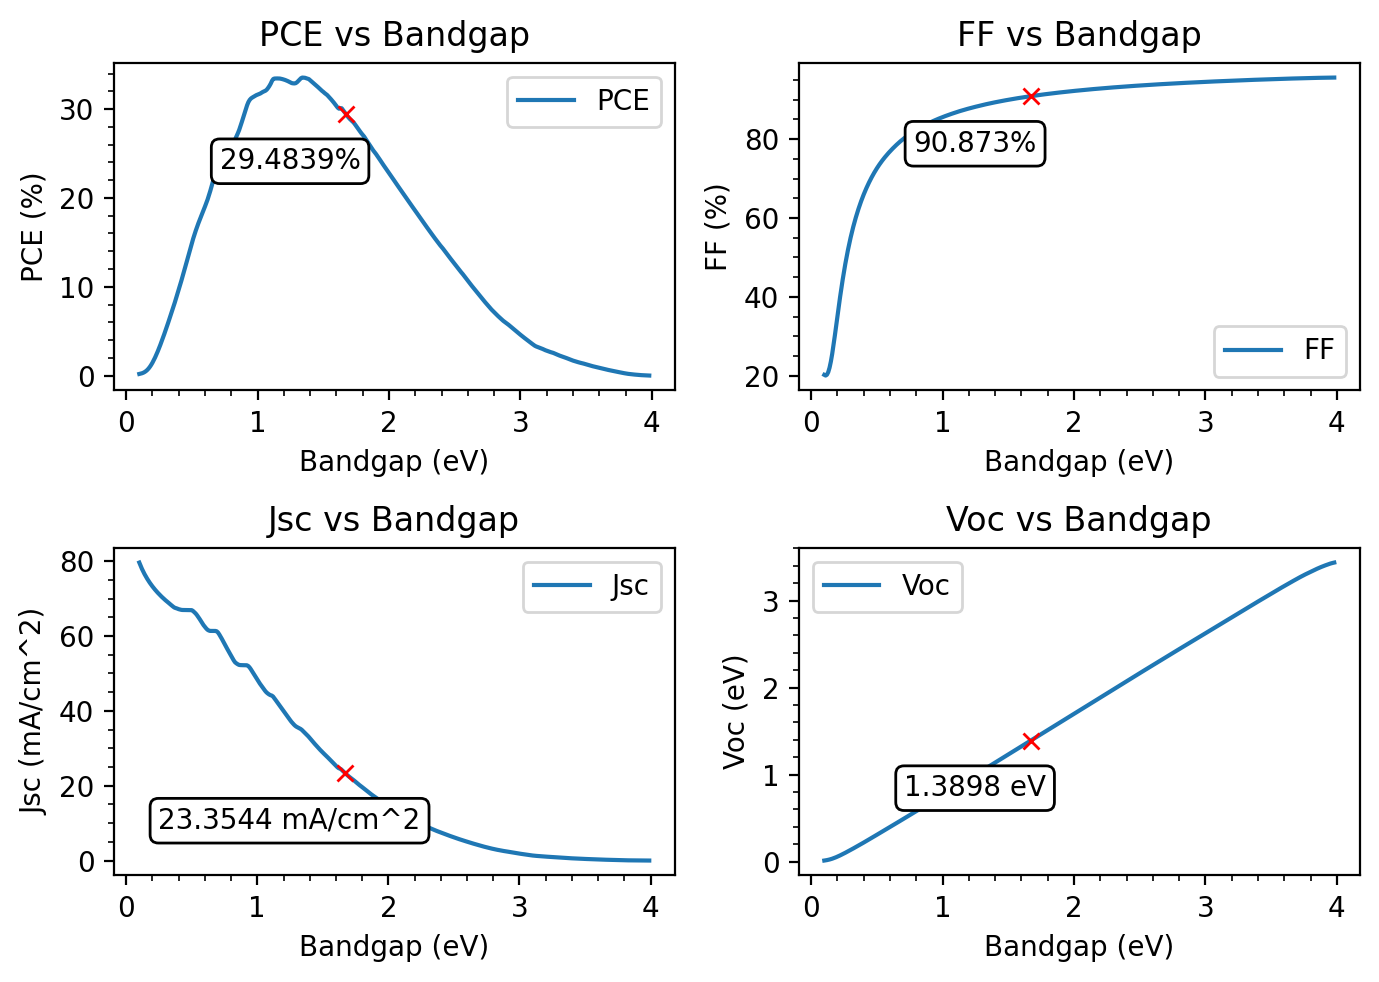

{'PCE': 29.4839,
 'FF': 90.873,
 'Jsc': 23.3544,
 'Voc': 1.3898,
 'J0': 1.0501571937976296e-22}

In [3]:
solve_DBL(1.67, plot=True)